In [9]:
# Cell 1: Imports and Load Data for Classification
# (This cell remains largely the same as your provided version, ensuring FEATURES_DIR and MODEL_OUTPUT_DIR are correct)
# Make sure to re-run this cell if you restart your notebook.

import pandas as pd
import numpy as np
import os
from pathlib import Path
import datetime as dt
from datetime import timezone, timedelta
import logging
import json # For saving feature_columns_list and imputation_values
import joblib # For saving the model and scaler

from sklearn.model_selection import train_test_split # We'll do a chronological split manually
# RandomForest will be imported in Cell 3
from sklearn.preprocessing import StandardScaler # For feature scaling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix

# --- Logging Setup ---
logger_name = f"model_training_classifier_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}"
logger = logging.getLogger(logger_name)
if not logger.handlers:
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s.%(funcName)s:%(lineno)d - %(message)s')
    ch = logging.StreamHandler()
    ch.setFormatter(formatter)
    logger.addHandler(ch)
else:
    logger.setLevel(logging.INFO)

# --- Configuration ---
# Assuming train.ipynb is in /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/train/
current_notebook_dir = Path.cwd()
logger.info(f"Cell 1: current_notebook_dir resolved to: {current_notebook_dir.resolve()}")

# FEATURES_DIR should point to .../kalshi/notebooks/features
FEATURES_DIR = current_notebook_dir.parent / "features"
logger.info(f"Cell 1: Attempting to find feature files in: {FEATURES_DIR.resolve()}")

try:
    if not FEATURES_DIR.exists():
        # This fallback assumes your project structure might be /kalshi/features directly
        # And train.ipynb is in /kalshi/notebooks/train
        alt_features_dir = current_notebook_dir.parent.parent / "features"
        logger.warning(f"Primary FEATURES_DIR {FEATURES_DIR.resolve()} not found. Trying alternative: {alt_features_dir.resolve()}")
        if alt_features_dir.exists():
            FEATURES_DIR = alt_features_dir
            logger.info(f"Using alternative FEATURES_DIR: {FEATURES_DIR.resolve()}")
        else:
            logger.error(f"Neither primary nor alternative FEATURES_DIR exists. Original: {FEATURES_DIR.resolve()}, Alt: {alt_features_dir.resolve()}")
            # Let the glob below fail more explicitly if FEATURES_DIR is truly wrong.
            pass

    feature_glob_pattern = "kalshi_btc_features_target_v2_filtered_15m_*.csv"
    feature_files = sorted(FEATURES_DIR.glob(feature_glob_pattern), key=os.path.getctime, reverse=True)

    if not feature_files:
        logger.warning(f"No '{feature_glob_pattern}' files found in {FEATURES_DIR.resolve()}. "
                       f"Falling back to 'kalshi_btc_features_target_v1_filtered_*.csv' (older version)...")
        feature_glob_pattern_v1_filt = "kalshi_btc_features_target_v1_filtered_*.csv"
        feature_files = sorted(FEATURES_DIR.glob(feature_glob_pattern_v1_filt), key=os.path.getctime, reverse=True)
        if not feature_files:
            raise FileNotFoundError(f"No feature CSV files found in {FEATURES_DIR.resolve()} matching EITHER "
                                    f"'{feature_glob_pattern}' OR '{feature_glob_pattern_v1_filt}'")

    FEATURES_CSV_PATH = feature_files[0]
    logger.info(f"Using features CSV: {FEATURES_CSV_PATH.resolve()}")

except FileNotFoundError as e:
    logger.critical(str(e))
    FEATURES_CSV_PATH = None
except Exception as e:
    logger.critical(f"Error finding features CSV: {e}", exc_info=True)
    FEATURES_CSV_PATH = None

# MODEL_OUTPUT_DIR should point to .../kalshi/notebooks/trained_models/rf
MODEL_OUTPUT_DIR = current_notebook_dir.parent / "trained_models" / "rf"
logger.info(f"Cell 1: Intended MODEL_OUTPUT_DIR: {MODEL_OUTPUT_DIR.resolve()}")

# --- More Robust Directory Creation and Check ---
try:
    MODEL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    if MODEL_OUTPUT_DIR.exists() and MODEL_OUTPUT_DIR.is_dir():
        logger.info(f"Successfully ensured MODEL_OUTPUT_DIR exists and is a directory: {MODEL_OUTPUT_DIR.resolve()}")
        # Test writability (optional, but can help diagnose permission issues early)
        # test_file_path = MODEL_OUTPUT_DIR / f"test_write_{dt.datetime.now().strftime('%Y%m%d%H%M%S')}.txt"
        # try:
        #     with open(test_file_path, 'w') as f_test:
        #         f_test.write("test")
        #     os.remove(test_file_path)
        #     logger.info(f"Write test to MODEL_OUTPUT_DIR successful.")
        # except Exception as e_write:
        #     logger.error(f"CRITICAL: Failed write test to MODEL_OUTPUT_DIR {MODEL_OUTPUT_DIR.resolve()}. Error: {e_write}. CHECK PERMISSIONS.")
        #     # Potentially raise an error here or set a flag to prevent further execution
    else:
        logger.error(f"CRITICAL: Failed to create or verify MODEL_OUTPUT_DIR: {MODEL_OUTPUT_DIR.resolve()}. It might not be a directory or creation failed.")
        # This should ideally not happen if mkdir was successful without error.
except Exception as e_mkdir:
    logger.error(f"CRITICAL: Exception during MODEL_OUTPUT_DIR creation for {MODEL_OUTPUT_DIR.resolve()}: {e_mkdir}. CHECK PATH AND PERMISSIONS.")
    # If directory creation fails, subsequent saves will fail.
    # You might want to raise the exception here to stop the notebook.
    # raise # Uncomment to stop execution if directory cannot be made

# --- Load the Features DataFrame ---
df_model_data = pd.DataFrame()
if FEATURES_CSV_PATH and FEATURES_CSV_PATH.exists():
    try:
        df_model_data = pd.read_csv(FEATURES_CSV_PATH)
        logger.info(f"Successfully loaded features data from: {FEATURES_CSV_PATH.resolve()}")
        logger.info(f"Shape of loaded data: {df_model_data.shape}")
        print("--- Data Head (Raw from CSV) ---")
        with pd.option_context('display.max_columns', None): print(df_model_data.head())
        print("\n--- Data Info (Raw from CSV) ---")
        df_model_data.info(verbose=True, show_counts=True)
    except Exception as e:
        logger.critical(f"Error loading features CSV {FEATURES_CSV_PATH.resolve()}: {e}")
else:
    if FEATURES_CSV_PATH: logger.critical(f"Features CSV file not found: {FEATURES_CSV_PATH.resolve()}")
    else: logger.critical("FEATURES_CSV_PATH was not set. Cannot load data.")

if df_model_data.empty: logger.warning("DataFrame df_model_data is empty. Subsequent cells might fail.")

2025-05-22 01:35:44,339 - INFO - model_training_classifier_20250522_013544.<module>:35 - Cell 1: current_notebook_dir resolved to: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/train
2025-05-22 01:35:44,339 - INFO - model_training_classifier_20250522_013544.<module>:39 - Cell 1: Attempting to find feature files in: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features
2025-05-22 01:35:44,341 - INFO - model_training_classifier_20250522_013544.<module>:68 - Using features CSV: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features/kalshi_btc_features_target_v2_filtered_15m_20250521_163917.csv
2025-05-22 01:35:44,341 - INFO - model_training_classifier_20250522_013544.<module>:79 - Cell 1: Intended MODEL_OUTPUT_DIR: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/rf
2025-05-22 01:35:44,348 - INFO - model_training_classifier_20250522_013544.<module>:85 - Successfully ensured MODEL_OUTPUT_DIR exists and is a directory: /Users/omarabul

--- Data Head (Raw from CSV) ---
          kalshi_market_ticker  decision_point_ts_utc  kalshi_strike_price  \
0  KXBTCD-25MAY1522-T106249.99             1747357200            106249.99   
1  KXBTCD-25MAY1522-T106249.99             1747357260            106249.99   
2  KXBTCD-25MAY1522-T106249.99             1747357320            106249.99   
3  KXBTCD-25MAY1522-T106249.99             1747357380            106249.99   
4  KXBTCD-25MAY1522-T106249.99             1747357440            106249.99   

   btc_price_t_minus_1  btc_mom_5m  btc_mom_10m  btc_mom_15m  btc_mom_30m  \
0            103764.81       73.29       -69.79      -182.17        22.80   
1            103709.10       17.67      -111.60      -246.90       -68.90   
2            103785.66       83.21         7.89      -114.10      -109.26   
3            103691.25      -34.40         5.91      -227.89      -285.74   
4            103629.36     -110.19       -98.42      -303.61      -299.95   

   btc_mom_60m  btc_vol_15m  btc_sm

In [10]:
# Cell 2: Data Preprocessing, Target Transformation, Feature Selection, and Splitting
# THIS CELL IS SIGNIFICANTLY MODIFIED FOR IMUTATION

if df_model_data.empty:
    logger.error("df_model_data is empty. Cannot proceed. Ensure Cell 1 ran correctly.")
    # Initialize to prevent errors in subsequent cells if this path is taken
    X, y, X_train, y_train, X_test, y_test, X_train_scaled_df, X_test_scaled_df = [pd.DataFrame()]*8
    scaler = None
    imputation_values = {}
else:
    logger.info(f"Starting preprocessing for df_model_data with shape: {df_model_data.shape}")

    # --- 1. Ensure Chronological Order ---
    df_model_data.sort_values(by='decision_point_ts_utc', inplace=True)
    df_model_data.reset_index(drop=True, inplace=True)
    logger.info("Data sorted by 'decision_point_ts_utc'.")

    # --- 2. Define Target Variable ---
    original_target_col = 'TARGET_btc_diff_from_strike'
    classification_target_col = 'TARGET_market_resolves_yes'
    if original_target_col not in df_model_data.columns:
        raise ValueError(f"Missing required column for target: {original_target_col}")
    df_model_data[classification_target_col] = (df_model_data[original_target_col] > 0).astype(int)
    logger.info(f"Created binary classification target '{classification_target_col}'.")
    logger.info(f"Value counts for '{classification_target_col}':\n{df_model_data[classification_target_col].value_counts(normalize=True)}")

    # --- 3. Define Feature Columns ---
    identifier_cols = ['kalshi_market_ticker', 'decision_point_ts_utc', 'kalshi_strike_price']
    feature_columns = [
        col for col in df_model_data.columns
        if col not in identifier_cols + [original_target_col, classification_target_col]
    ]
    logger.info(f"Identified {len(feature_columns)} feature columns.")
    # logger.info(f"Feature columns list:\n{feature_columns}") # Uncomment for verbosity

    # --- 4. Initial NaN Check (on df_model_data for features) ---
    nan_summary_before_processing = df_model_data[feature_columns].isnull().sum()
    nan_summary_before_processing = nan_summary_before_processing[nan_summary_before_processing > 0].sort_values(ascending=False)
    if not nan_summary_before_processing.empty:
        logger.info(f"NaN values in feature columns of df_model_data BEFORE ANY imputation/split:\n{nan_summary_before_processing}")
    else:
        logger.info("No NaNs found in feature columns of df_model_data before any imputation/split.")

    # --- 5. Drop rows with NaN in target *before* splitting ---
    # This ensures y_train and y_test do not have NaNs.
    original_len_before_target_nan_drop = len(df_model_data)
    df_model_data.dropna(subset=[classification_target_col], inplace=True)
    logger.info(f"Dropped {original_len_before_target_nan_drop - len(df_model_data)} rows due to NaN in target '{classification_target_col}'.")
    logger.info(f"Shape of df_model_data after dropping NaNs in target: {df_model_data.shape}")


    # --- 6. Prepare X and y (from the potentially reduced df_model_data) ---
    if df_model_data.empty:
        logger.error("df_model_data is empty after dropping NaNs in target. Cannot proceed.")
        X, y, X_train, y_train, X_test, y_test, X_train_scaled_df, X_test_scaled_df = [pd.DataFrame()]*8
        scaler = None
        imputation_values = {}
    else:
        X = df_model_data[feature_columns].copy()
        y = df_model_data[classification_target_col].copy()

        # --- 7. Chronological Train-Test Split ---
        split_ratio = 0.8
        split_index = int(len(X) * split_ratio)

        # Ensure X_train, y_train, X_test, y_test are fresh copies for imputation
        X_train = X.iloc[:split_index].copy()
        y_train = y.iloc[:split_index].copy()
        X_test = X.iloc[split_index:].copy()
        y_test = y.iloc[split_index:].copy()

        logger.info(f"Data split chronologically:")
        logger.info(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        logger.info(f"  X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
        
        # Log NaN counts per column in X_train and X_test BEFORE imputation
        logger.info(f"NaNs in X_train before imputation:\n{X_train.isnull().sum()[X_train.isnull().sum() > 0]}")
        logger.info(f"NaNs in X_test before imputation:\n{X_test.isnull().sum()[X_test.isnull().sum() > 0]}")


        # --- 8. Calculate Imputation Values from X_train and Apply ---
        imputation_values = {}
        logger.info("Calculating imputation values from X_train and applying to X_train & X_test...")

        # Helper to apply imputation
        def apply_imputation_value(df, col_name, value_to_fill):
            if col_name in df.columns:
                df[col_name].fillna(value_to_fill, inplace=True)

        # Stage 1: Impute 'kalshi_yes_bid' and 'kalshi_yes_ask' first (fixed values)
        # These are components for 'kalshi_spread' and 'kalshi_mid_price'
        if 'kalshi_yes_bid' in feature_columns:
            val = 0.0 # Fixed value from original logic
            imputation_values['kalshi_yes_bid'] = val
            apply_imputation_value(X_train, 'kalshi_yes_bid', val)
            apply_imputation_value(X_test, 'kalshi_yes_bid', val)

        if 'kalshi_yes_ask' in feature_columns:
            val = 100.0 # Fixed value from original logic
            imputation_values['kalshi_yes_ask'] = val
            apply_imputation_value(X_train, 'kalshi_yes_ask', val)
            apply_imputation_value(X_test, 'kalshi_yes_ask', val)

        # Stage 2: Re-calculate derived features ('kalshi_spread', 'kalshi_mid_price')
        # using (now imputed) components.
        # These might still have NaNs if their components were fully NaN (unlikely after fixed imputation)
        # or if the columns themselves were entirely NaN to begin with.
        if 'kalshi_spread' in feature_columns and 'kalshi_yes_ask' in X_train.columns and 'kalshi_yes_bid' in X_train.columns:
            X_train['kalshi_spread'] = X_train['kalshi_yes_ask'] - X_train['kalshi_yes_bid']
            X_test['kalshi_spread'] = X_test['kalshi_yes_ask'] - X_test['kalshi_yes_bid']

        if 'kalshi_mid_price' in feature_columns and 'kalshi_yes_ask' in X_train.columns and 'kalshi_yes_bid' in X_train.columns:
            X_train['kalshi_mid_price'] = (X_train['kalshi_yes_bid'] + X_train['kalshi_yes_ask']) / 2.0
            X_test['kalshi_mid_price'] = (X_test['kalshi_yes_bid'] + X_test['kalshi_yes_ask']) / 2.0

        # Stage 3: Determine and apply imputation for all other features (including the derived ones)
        for col in feature_columns:
            if col in imputation_values: # Already handled (e.g., kalshi_yes_bid, kalshi_yes_ask)
                continue

            fill_value_for_col = np.nan # Initialize

            # Determine fill_value_for_col based on X_train's data for 'col'
            if X_train[col].isnull().any(): # If there are NaNs in X_train for this column
                if 'btc_mom' in col or 'kalshi_mid_chg' in col: fill_value_for_col = 0.0
                elif 'btc_vol' in col or 'kalshi_mid_vol' in col: fill_value_for_col = X_train[col].median()
                elif 'btc_sma' in col or 'btc_ema' in col: fill_value_for_col = X_train[col].median()
                elif 'btc_price_vs_sma' in col or 'btc_price_vs_ema' in col: fill_value_for_col = 1.0
                elif 'btc_rsi' in col: fill_value_for_col = 50.0
                elif 'btc_atr' in col: fill_value_for_col = X_train[col].median()
                elif col == 'distance_to_strike_norm_atr': fill_value_for_col = 0.0
                elif col == 'kalshi_vs_btc_implied_spread': fill_value_for_col = 0.0
                elif col == 'kalshi_spread': fill_value_for_col = X_train[col].median() # Fallback for derived spread
                elif col == 'kalshi_mid_price': fill_value_for_col = X_train[col].median() # Fallback for derived mid
                elif 'kalshi_volume_t_minus_1' in col or 'kalshi_open_interest_t_minus_1' in col: fill_value_for_col = 0.0
                else: # General fallback for any other unexpected column with NaNs
                    logger.warning(f"Col '{col}' in X_train has NaNs; using its median for imputation.")
                    fill_value_for_col = X_train[col].median()
                
                if pd.isna(fill_value_for_col): # If median calculation resulted in NaN (e.g. all NaNs in col)
                    logger.warning(f"Median for '{col}' in X_train is NaN. Using 0.0 as fallback imputation value.")
                    fill_value_for_col = 0.0
            else: # No NaNs in X_train[col]. Store a representative value for X_test if it has NaNs.
                  # For consistency with how NaNs would have been filled.
                if 'btc_mom' in col or 'kalshi_mid_chg' in col: fill_value_for_col = 0.0
                elif 'btc_price_vs_sma' in col or 'btc_price_vs_ema' in col: fill_value_for_col = 1.0
                elif 'btc_rsi' in col: fill_value_for_col = 50.0
                elif col == 'distance_to_strike_norm_atr': fill_value_for_col = 0.0
                elif col == 'kalshi_vs_btc_implied_spread': fill_value_for_col = 0.0
                elif col == 'kalshi_spread': fill_value_for_col = 100.0 # Default if no NaNs, consistent with typical range
                elif col == 'kalshi_mid_price': fill_value_for_col = 50.0  # Default if no NaNs
                elif 'kalshi_volume_t_minus_1' in col or 'kalshi_open_interest_t_minus_1' in col: fill_value_for_col = 0.0
                else: # For vol, sma, ema, atr - if no NaNs, their "imputation value" is their median from X_train
                    fill_value_for_col = X_train[col].median() if not X_train[col].empty else 0.0
                    if pd.isna(fill_value_for_col): fill_value_for_col = 0.0 # Final fallback

            imputation_values[col] = fill_value_for_col
            apply_imputation_value(X_train, col, fill_value_for_col)
            apply_imputation_value(X_test, col, fill_value_for_col)

        logger.info(f"Imputation values map created with {len(imputation_values)} entries.")
        # logger.debug(f"Imputation values: {imputation_values}") # Uncomment for verbose output

        # --- 9. Final NaN Check and Drop (as a Safety Net) ---
        if X_train.isnull().any().any(): # Check if any NaNs exist in any column of X_train
            nan_cols_train = X_train.columns[X_train.isnull().any()].tolist()
            logger.warning(f"X_train still has NaNs after imputation in columns: {nan_cols_train}. Dropping affected rows.")
            rows_before_train = len(X_train)
            X_train.dropna(inplace=True)
            y_train = y_train.loc[X_train.index] # Align y_train
            logger.info(f"Dropped {rows_before_train - len(X_train)} rows from X_train/y_train due to persistent NaNs.")

        if X_test.isnull().any().any():
            nan_cols_test = X_test.columns[X_test.isnull().any()].tolist()
            logger.warning(f"X_test still has NaNs after imputation in columns: {nan_cols_test}. Dropping affected rows.")
            rows_before_test = len(X_test)
            X_test.dropna(inplace=True)
            y_test = y_test.loc[X_test.index] # Align y_test
            logger.info(f"Dropped {rows_before_test - len(X_test)} rows from X_test/y_test due to persistent NaNs.")

        logger.info(f"Shapes after all imputation and final NaN drop:")
        logger.info(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
        logger.info(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")

        if X_train.empty or X_test.empty:
            logger.error("X_train or X_test is empty after all NaN handling. Cannot proceed with scaling.")
            X_train_scaled_df, X_test_scaled_df = pd.DataFrame(), pd.DataFrame() # Ensure empty DFs
            scaler = None # Ensure scaler is None
        else:
            # --- 10. Feature Scaling ---
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
            X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
            logger.info("Features scaled using StandardScaler.")

            # --- 11. Save Scaler, Feature List, and Imputation Values ---
            scaler_path_v2 = MODEL_OUTPUT_DIR / "feature_scaler_classifier_v2.joblib"
            joblib.dump(scaler, scaler_path_v2)
            logger.info(f"Scaler for V2 features saved to: {scaler_path_v2}")

            feature_columns_list_path_v2 = MODEL_OUTPUT_DIR / "feature_columns_classifier_v2.json"
            with open(feature_columns_list_path_v2, 'w') as f:
                json.dump(feature_columns, f)
            logger.info(f"List of V2 feature columns ({len(feature_columns)} features) saved to: {feature_columns_list_path_v2}")

            imputation_values_path_v2 = MODEL_OUTPUT_DIR / "imputation_values_classifier_v2.json"
            serializable_imputation_values = {}
            for k, v_val in imputation_values.items():
                if isinstance(v_val, (np.generic, np.ndarray)): # Handle numpy types
                    serializable_imputation_values[k] = v_val.item() if isinstance(v_val, np.generic) else v_val.tolist()
                else:
                    serializable_imputation_values[k] = v_val
            with open(imputation_values_path_v2, 'w') as f:
                json.dump(serializable_imputation_values, f, indent=4)
            logger.info(f"Imputation values for V2 features saved to: {imputation_values_path_v2}")

            # Log chronological range of training and test sets
            if not X_train.empty and 'decision_point_ts_utc' in df_model_data.columns:
                try:
                    # Use .iloc[0] and .iloc[-1] on the original X_train/X_test before potential dropna
                    # to get the intended boundary timestamps from df_model_data.
                    # However, X_train.index might have changed if rows were dropped.
                    # It's safer to use the indices that are confirmed to be in the final X_train/X_test.
                    train_start_ts_unix = df_model_data.loc[X_train.index[0], 'decision_point_ts_utc']
                    train_end_ts_unix = df_model_data.loc[X_train.index[-1], 'decision_point_ts_utc']
                    test_start_ts_unix = df_model_data.loc[X_test.index[0], 'decision_point_ts_utc']
                    test_end_ts_unix = df_model_data.loc[X_test.index[-1], 'decision_point_ts_utc']

                    train_start_ts_iso = dt.datetime.fromtimestamp(train_start_ts_unix, tz=timezone.utc).isoformat()
                    train_end_ts_iso = dt.datetime.fromtimestamp(train_end_ts_unix, tz=timezone.utc).isoformat()
                    test_start_ts_iso = dt.datetime.fromtimestamp(test_start_ts_unix, tz=timezone.utc).isoformat()
                    test_end_ts_iso = dt.datetime.fromtimestamp(test_end_ts_unix, tz=timezone.utc).isoformat()

                    logger.info(f"  Training data from: {train_start_ts_iso} to {train_end_ts_iso}")
                    logger.info(f"  Test data from:     {test_start_ts_iso} to {test_end_ts_iso}")
                except IndexError:
                    logger.warning("Could not determine train/test date ranges due to empty X_train/X_test after NaN drops.")
                except KeyError as e:
                     logger.warning(f"Could not determine train/test date ranges, KeyError: {e}. Indices might be out of bound for df_model_data.")
            else:
                logger.warning("Train set is empty or 'decision_point_ts_utc' missing. Cannot log date ranges.")

2025-05-22 01:35:47,175 - INFO - model_training_classifier_20250522_013544.<module>:11 - Starting preprocessing for df_model_data with shape: (1157220, 44)
2025-05-22 01:35:47,264 - INFO - model_training_classifier_20250522_013544.<module>:16 - Data sorted by 'decision_point_ts_utc'.
2025-05-22 01:35:47,267 - INFO - model_training_classifier_20250522_013544.<module>:24 - Created binary classification target 'TARGET_market_resolves_yes'.
2025-05-22 01:35:47,270 - INFO - model_training_classifier_20250522_013544.<module>:25 - Value counts for 'TARGET_market_resolves_yes':
TARGET_market_resolves_yes
1    0.519676
0    0.480324
Name: proportion, dtype: float64
2025-05-22 01:35:47,270 - INFO - model_training_classifier_20250522_013544.<module>:33 - Identified 40 feature columns.
2025-05-22 01:35:47,337 - INFO - model_training_classifier_20250522_013544.<module>:40 - NaN values in feature columns of df_model_data BEFORE ANY imputation/split:
kalshi_mid_vol_10m                524325
kalshi_mi

2025-05-22 01:40:57,049 - INFO - model_training_classifier_20250522_013544.<module>:10 - --- Starting Classification Model Training (Calibrated Random Forest) ---
2025-05-22 01:40:57,049 - INFO - model_training_classifier_20250522_013544.<module>:23 - Using Regularized RF Params for OOB check and CalibratedCV: {'n_estimators': 200, 'max_depth': 8, 'min_samples_split': 100, 'min_samples_leaf': 50, 'class_weight': 'balanced_subsample', 'random_state': 42, 'n_jobs': -1}
2025-05-22 01:40:57,050 - INFO - model_training_classifier_20250522_013544.<module>:30 - Fitting base RandomForest model (for OOB check) on 925776 samples...
2025-05-22 01:41:56,136 - INFO - model_training_classifier_20250522_013544.<module>:36 - Base RandomForest model training complete for OOB check.
2025-05-22 01:41:56,136 - INFO - model_training_classifier_20250522_013544.<module>:38 -   Base Model Out-of-Bag (OOB) Score (Regularized): 0.8673
2025-05-22 01:41:56,136 - INFO - model_training_classifier_20250522_013544.<m

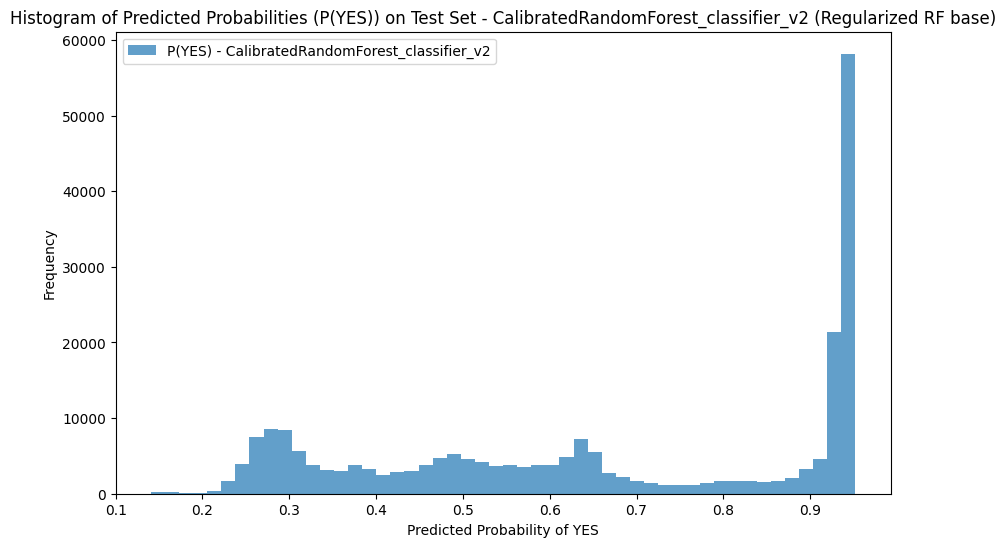

2025-05-22 01:43:24,578 - INFO - model_training_classifier_20250522_013544.<module>:96 - Description of P(YES) for CalibratedRandomForest_classifier_v2 (Regularized RF base) on test set:
count    231444.000000
mean          0.659222
std           0.259424
min           0.140517
25%           0.424946
50%           0.644090
75%           0.936134
max           0.952088
2025-05-22 01:43:24,578 - INFO - model_training_classifier_20250522_013544.<module>:99 - 
--- Confusion Matrix (Test Set) - CalibratedRandomForest_classifier_v2 (Regularized RF base) ---
2025-05-22 01:43:24,581 - INFO - model_training_classifier_20250522_013544.<module>:101 - 
[[ 73313  39017]
 [  3586 115528]]
2025-05-22 01:43:24,581 - INFO - model_training_classifier_20250522_013544.<module>:104 -   True Negatives (TN):  73313
2025-05-22 01:43:24,581 - INFO - model_training_classifier_20250522_013544.<module>:105 -   False Positives (FP): 39017 (Type I Error)
2025-05-22 01:43:24,581 - INFO - model_training_classifier_20


--- Sample of Test Set Predictions vs Actuals (CalibratedRandomForest_classifier_v2, Regularized RF base) ---
        actual_target_resolves_yes  predicted_class_resolves_yes  predicted_proba_resolves_yes  original_target_diff         kalshi_market_ticker  decision_point_ts_utc
925776                           0                             0                      0.320303              -1303.46  KXBTCD-25MAY0917-T104499.99             1746692640
925777                           1                             1                      0.505475                529.52  KXBTCD-25MAY0817-T101999.99             1746692640
925778                           1                             1                      0.546122                696.54  KXBTCD-25MAY0917-T102499.99             1746692640
925779                           1                             1                      0.653453               2196.54  KXBTCD-25MAY0917-T100999.99             1746692640
925780                           1          

In [12]:
# Cell 3: Classification Model Training and Evaluation
# CORRECTED: Ensure CalibratedClassifierCV uses the regularized RF parameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV # For probability calibration

if 'X_train_scaled_df' not in globals() or X_train_scaled_df.empty:
    logger.error("Scaled training data (X_train_scaled_df) not found or is empty. Please ensure Cell 2 ran successfully.")
else:
    logger.info("--- Starting Classification Model Training (Calibrated Random Forest) ---")

    # --- Define Regularized RandomForest Parameters ---
    REGULARIZED_RF_PARAMS = {
        'n_estimators': 200,
        'max_depth': 8,             # More regularized
        'min_samples_split': 100,   # More regularized
        'min_samples_leaf': 50,     # More regularized
        'class_weight': 'balanced_subsample',
        'random_state': 42,
        'n_jobs': -1,
        # oob_score is True for the base_rf_model for checking, False for CalibratedCV's internal one
    }
    logger.info(f"Using Regularized RF Params for OOB check and CalibratedCV: {REGULARIZED_RF_PARAMS}")

    # --- 1. Initialize Base RandomForestClassifier Model (for OOB check) ---
    base_rf_model_for_oob = RandomForestClassifier(**REGULARIZED_RF_PARAMS, oob_score=True)
    
    model_name = "CalibratedRandomForest_classifier_v2" # Name remains v2, but internally it's more regularized
    
    logger.info(f"Fitting base RandomForest model (for OOB check) on {X_train_scaled_df.shape[0]} samples...")
    if 'y_train' not in globals() or y_train.empty:
        logger.error("y_train (binary target) is not available. Cannot train base model.")
    else:
        try:
            base_rf_model_for_oob.fit(X_train_scaled_df, y_train) # Fit on scaled data
            logger.info(f"Base RandomForest model training complete for OOB check.")
            if hasattr(base_rf_model_for_oob, 'oob_score_') and base_rf_model_for_oob.oob_score_:
                 logger.info(f"  Base Model Out-of-Bag (OOB) Score (Regularized): {base_rf_model_for_oob.oob_score_:.4f}")
            else:
                logger.warning("  Base Model OOB Score not available (oob_score=True might not have run or failed).")
        except Exception as e:
            logger.error(f"Error fitting base RF model for OOB check: {e}", exc_info=True)
    
    # --- 2. Initialize and Train CalibratedClassifierCV (using REGULARIZED RF) ---
    logger.info(f"Training {model_name} (Calibrated RF with sigmoid) on {X_train_scaled_df.shape[0]} samples...")
    
    # Pass a NEW instance of RandomForestClassifier with the REGULARIZED parameters
    calibrated_classifier_model = CalibratedClassifierCV(
        RandomForestClassifier(**REGULARIZED_RF_PARAMS, oob_score=False), # oob_score=False for estimator in CalibratedCV
        method='sigmoid', 
        cv=3 # Number of folds for calibration
    )
    
    logger.info(f"Model parameters for CalibratedClassifierCV: {calibrated_classifier_model.get_params()}")
    
    if 'y_train' not in globals() or y_train.empty:
        logger.error("y_train (binary target) is not available. Cannot train calibrated model.")
    else:
        try:
            calibrated_classifier_model.fit(X_train_scaled_df, y_train) # Fit on scaled data
            logger.info(f"{model_name} model training complete.")

            # --- 3. Make Predictions on the Test Set ---
            logger.info(f"Making predictions with {model_name} on the test set ({X_test_scaled_df.shape[0]} samples)...\n")
            y_pred_test_class = calibrated_classifier_model.predict(X_test_scaled_df)
            y_pred_test_proba = calibrated_classifier_model.predict_proba(X_test_scaled_df)[:, 1]

            # --- 4. Evaluate Model Performance (Classification Metrics) ---
            if 'y_test' not in globals() or y_test.empty:
                logger.error("y_test (binary target) is not available. Cannot evaluate model.")
            else:
                accuracy = accuracy_score(y_test, y_pred_test_class)
                precision = precision_score(y_test, y_pred_test_class, zero_division=0)
                recall = recall_score(y_test, y_pred_test_class, zero_division=0)
                f1 = f1_score(y_test, y_pred_test_class, zero_division=0)
                try: roc_auc = roc_auc_score(y_test, y_pred_test_proba)
                except ValueError as e: logger.warning(f"Could not calculate ROC AUC: {e}"); roc_auc = np.nan
                logloss = log_loss(y_test, y_pred_test_proba)

                logger.info(f"--- {model_name} Evaluation Metrics (Test Set, Regularized RF base) ---") # Updated log message
                logger.info(f"  Accuracy:          {accuracy:.4f}")
                logger.info(f"  Precision:         {precision:.4f}")
                logger.info(f"  Recall (TPR):      {recall:.4f}")
                logger.info(f"  F1-Score:          {f1:.4f}")
                logger.info(f"  ROC AUC:           {roc_auc:.4f}")
                logger.info(f"  Log Loss:          {logloss:.4f}")

                import matplotlib.pyplot as plt
                plt.figure(figsize=(10,6))
                plt.hist(y_pred_test_proba, bins=50, alpha=0.7, label=f'P(YES) - {model_name}')
                plt.title(f'Histogram of Predicted Probabilities (P(YES)) on Test Set - {model_name} (Regularized RF base)') # Updated title
                plt.xlabel('Predicted Probability of YES')
                plt.ylabel('Frequency')
                plt.legend()
                plt.show()
                logger.info(f"Description of P(YES) for {model_name} (Regularized RF base) on test set:\n{pd.Series(y_pred_test_proba).describe().to_string()}")


                logger.info(f"\n--- Confusion Matrix (Test Set) - {model_name} (Regularized RF base) ---") # Updated log message
                cm = confusion_matrix(y_test, y_pred_test_class)
                logger.info(f"\n{cm}")
                try:
                    tn, fp, fn, tp = cm.ravel()
                    logger.info(f"  True Negatives (TN):  {tn}")
                    logger.info(f"  False Positives (FP): {fp} (Type I Error)")
                    logger.info(f"  False Negatives (FN): {fn} (Type II Error)")
                    logger.info(f"  True Positives (TP):  {tp}")
                except ValueError: logger.warning("Could not unpack full confusion matrix.")

                df_results_class = pd.DataFrame({
                    'actual_target_resolves_yes': y_test,
                    'predicted_class_resolves_yes': y_pred_test_class,
                    'predicted_proba_resolves_yes': y_pred_test_proba
                })
                if 'original_target_col' in globals() and original_target_col in df_model_data.columns and not X_test.empty :
                    df_results_class['original_target_diff'] = df_model_data.loc[X_test.index, original_target_col].values
                if 'kalshi_market_ticker' in df_model_data.columns and not X_test.empty:
                    df_results_class['kalshi_market_ticker'] = df_model_data.loc[X_test.index, 'kalshi_market_ticker'].values
                if 'decision_point_ts_utc' in df_model_data.columns and not X_test.empty:
                    df_results_class['decision_point_ts_utc'] = df_model_data.loc[X_test.index, 'decision_point_ts_utc'].values
                
                print(f"\n--- Sample of Test Set Predictions vs Actuals ({model_name}, Regularized RF base) ---")
                print(df_results_class.head(10).to_string())

                # --- 5. Inspect Feature Importances (from the BASE REGULARIZED RandomForest model used for OOB) ---
                logger.info(f"\n\n--- Feature Importances (from base REGULARIZED model of {model_name}) ---")
                
                if hasattr(base_rf_model_for_oob, 'feature_importances_'): # Use the regularized one
                    if 'feature_columns' not in globals() or not feature_columns:
                        logger.warning("feature_columns list not found or empty.")
                        feat_col_path = MODEL_OUTPUT_DIR / "feature_columns_classifier_v2.json"
                        if feat_col_path.exists():
                            with open(feat_col_path, 'r') as f_cols: loaded_feature_cols = json.load(f_cols)
                            if len(loaded_feature_cols) == X_train_scaled_df.shape[1]: feature_columns_for_importance = loaded_feature_cols
                            else: feature_columns_for_importance = [f"feature_{i}" for i in range(X_train_scaled_df.shape[1])]
                        else: feature_columns_for_importance = [f"feature_{i}" for i in range(X_train_scaled_df.shape[1])]
                    else: feature_columns_for_importance = feature_columns
                    
                    importances = pd.DataFrame({
                        'feature': feature_columns_for_importance, 
                        'importance': base_rf_model_for_oob.feature_importances_ # Use the regularized one
                    })
                    importances.sort_values(by='importance', ascending=False, inplace=True)
                    print("\nTop Feature Importances (from base REGULARIZED RF model):")
                    print(importances.head(30).to_string())
                else:
                    logger.warning(f"Could not retrieve feature importances from the base regularized RF model for {model_name}.")

                # --- 6. Save the Trained CALIBRATED Model (which now uses regularized RF base) ---
                model_path = MODEL_OUTPUT_DIR / f"{model_name}.joblib"
                joblib.dump(calibrated_classifier_model, model_path)
                logger.info(f"Trained {model_name} model (with regularized base) saved to: {model_path}")

                model_hyperparams = calibrated_classifier_model.get_params(deep=True)
                params_path = MODEL_OUTPUT_DIR / f"{model_name}_hyperparams.json"
                with open(params_path, 'w') as f:
                    serializable_params = {}
                    for k_param, v_param in model_hyperparams.items():
                        if isinstance(v_param, np.ndarray): serializable_params[k_param] = v_param.tolist()
                        elif isinstance(v_param, (np.bool_, np.integer, np.floating)): serializable_params[k_param] = v_param.item()
                        elif isinstance(v_param, (BaseException)): serializable_params[k_param] = str(v_param) # For estimator objects
                        else: serializable_params[k_param] = v_param
                    json.dump(serializable_params, f, indent=4, default=lambda o: '<not serializable>')
                logger.info(f"{model_name} hyperparameters saved to: {params_path}")
                
        except Exception as e:
            logger.critical(f"An error occurred during {model_name} model training or evaluation: {e}", exc_info=True)